In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 11: Simplified tree - Term/interest rate - ALE increase
Exploring the interest rate and term interaction, using a simplified model to help understand the reason for differences.  

Here, I use a custom single, simple tree model to demonstrate a case where the ALE and SHAP curves look similar to the full model curves.  This simplified model was generated by iteratively removing features from the base model, identifying individual trees with the behavior, and then pruning trees (not shown).  This simplified model can help understand why the 2 methods differ.

The simplified tree is fit to the training data to count node samples and get SHAP and ALE data

*This script takes about 1 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import scipy
import random
import importlib
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from sklearn.inspection import partial_dependence

In [3]:
from PyALE import ale
import shap

In [4]:
from interactions_package.interactions_package import ip_plot, ip_custom_tree
ip_plot.plot_defaults()

## Import Data

In [5]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) \
    .reset_index(drop=True)

In [6]:
train_samp_df.shape

(100000, 35)

In [7]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [8]:
train_df.shape

(874451, 35)

## Define the tree
The simplified tree has 3 features - annual income, interest rate, and term. I manually define the tree structure, and use it to instantiate an estimator object.  Then, I "fit" the estimator to get the counts of training data reaching each node.  This results in a single tree model that can be used by SHAP, ALE, or other methods.

In [9]:
cust_tree_dict = {
    'children_left': np.array([ 1, -1,  3,  5, -1, -1, -1]),
    'children_right': np.array([ 2, -1,  4,  6, -1, -1, -1]),
    'feature': np.array([ 2,  -2,  0,  1, -2, -2, -2]),
    'threshold': np.array([48, -2, 40000, 30.5, -2, -2, -2]),
    'n_node_samples': np.array([10000, 5000, 5000, 2500, 2500, 1250, 1250]),
    'impurity': np.array([0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1]),
    'value': np.array([0.023, 0.015, 0.032, 0.063, 0.029, 0.259, 1.787])}

In [10]:
feature_list = ['annual_inc', 'int_rate', 'term']

In [11]:
cust_tree_dict = {
    'children_left': np.array([ 1, -1,  3,  5, -1, -1, 7, -1, -1]),
    'children_right': np.array([ 2, -1,  4,  6, -1, -1, 8, -1, -1]),
    'feature': np.array([ 2,  -2,  0,  0, -2, -2, 1, -1, -1]),
    'threshold': np.array([48, -2, 40000, 4000, -2, -2, 30, -2, -2 ]),
    'n_node_samples': np.array([10000, 5000, 5000, 2500, 2500, 1250, 1250, 625, 625]),
    'impurity': np.array([0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1]),
    'value': np.array([0.023, 0.015, 0.032, 0.062, 0.029, -0.27, 0.063, 0.259, 1.787])}

In [12]:
# The exact tree
cust_tree_dict = {'children_left': np.array([ 1, -1,  3,  4, -1,  6, -1, -1, -1]),
 'children_right': np.array([ 2, -1,  8,  5, -1,  7, -1, -1, -1]),
 'feature': np.array([ 2,  1,  0,  0,  1,  1, -2, -2,  1]),
 'threshold': np.array([ 4.80000000e+01,  1.99799995e+01,  4.02840000e+04,  3.95000000e+03,
         2.56300001e+01,  3.09650002e+01, -2.00000000e+00, -2.00000000e+00,
         2.19849997e+01]),
 'n_node_samples': np.array([4.70858e+05, 3.57527e+05, 1.13331e+05, 1.07830e+04, 6.80000e+01,
        1.07150e+04, 1.06990e+04, 1.60000e+01, 1.02548e+05]),
 'impurity': np.array([0.0e+000, 4.9e-324, 9.9e-324, 1.5e-323, 2.0e-323, 3.5e-323,
        4.0e-323, 4.4e-323, 4.9e-323]),
 'value': np.array([ 0.02299051,  0.01454258,  0.03233632,  0.06162073, -0.26970194,
         0.06306868,  0.25861977,  1.78682742,  0.02867946])}

In [13]:
cust_tree_dict = {
    'children_left': np.array([ 1, -1,  3,  5, -1, -1, 7, -1, -1]),
    'children_right': np.array([ 2, -1,  4,  6, -1, -1, 8, -1, -1]),
    'feature': np.array([ 2,  -2,  0,  0, -2, -2, 1, -1, -1]),
    'threshold': np.array([48.0, -2, 4.02840000e+04, 3.95000000e+03, -2, -2, 3.09650002e+01, -2, -2 ]),
    'n_node_samples': np.array([10000, 5000, 5000, 2500, 2500, 1250, 1250, 625, 625]),
    'impurity': np.array([0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1]),
    'value': np.array([0.02299051, 0.01454258, 0.03233632, 0.06162073, 0.029, -0.26970194, 0.06306868, 0.25861977, 1.78682742])}

# Testing standard levels.  30 is OK, 40k fine, 45k.   
cust_tree_dict = {
    'children_left': np.array([ 1, -1,  3,  5, -1, -1, 7, -1, -1]),
    'children_right': np.array([ 2, -1,  4,  6, -1, -1, 8, -1, -1]),
    'feature': np.array([ 2,  -2,  0,  0, -2, -2, 1, -1, -1]),
    'threshold': np.array([48, -2, 30000, 5000, -2, -2, 30, -2, -2 ]),
    'n_node_samples': np.array([10000, 5000, 5000, 2500, 2500, 1250, 1250, 625, 625]),
    'impurity': np.array([0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1]),
    'value': np.array([0.02299051, 0.01454258, 0.03233632, 0.06162073, 0.029, -0.26970194, 0.06306868, 0.25861977, 1.78682742])}

In [14]:
[len(cust_tree_dict[k]) for k in cust_tree_dict.keys()]

[9, 9, 9, 9, 9, 9, 9]

In [15]:
importlib.reload(ip_custom_tree)

<module 'interactions_package.interactions_package.ip_custom_tree' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/code/interactions_package/interactions_package/ip_custom_tree.py'>

In [16]:
tree_estimator = ip_custom_tree.TemplateClassifier(cust_tree_dict)

In [17]:
tree_estimator.fit(train_df[feature_list])

TemplateClassifier(max_depth=6,
                   tree_dict={'children_left': array([ 1, -1,  3,  5, -1, -1,  7, -1, -1]),
                              'children_right': array([ 2, -1,  4,  6, -1, -1,  8, -1, -1]),
                              'feature': array([ 2, -2,  0,  0, -2, -2,  1, -1, -1]),
                              'impurity': array([0.  , 0.01, 0.01, 0.01, 0.01, 0.01, 0.1 , 0.1 , 0.1 ]),
                              'n_node_samples': array([874451, 663751, 210700,  19976, 190724,    128,  19848,  19820,
           28]),
                              'threshold': array([ 4.80000000e+01, -2.00000000e+00,  4.02840000e+04,  3.95000000e+03,
       -2.00000000e+00, -2.00000000e+00,  3.09650002e+01, -2.00000000e+00,
       -2.00000000e+00]),
                              'value': array([ 0.02299051,  0.01454258,  0.03233632,  0.06162073,  0.029     ,
       -0.26970194,  0.06306868,  0.25861977,  1.78682742])})

[Text(0.4, 0.9, 'node #0\nterm <= 48.0\nsamples = 874451\nvalue = 0.023'),
 Text(0.2, 0.7, 'node #1\nsamples = 663751\nvalue = 0.015'),
 Text(0.6, 0.7, 'node #2\nannual_inc <= 40284.0\nsamples = 210700\nvalue = 0.032'),
 Text(0.4, 0.5, 'node #3\nannual_inc <= 3950.0\nsamples = 19976\nvalue = 0.062'),
 Text(0.2, 0.3, 'node #5\nsamples = 128\nvalue = -0.27'),
 Text(0.6, 0.3, 'node #6\nint_rate <= 30.965\nsamples = 19848\nvalue = 0.063'),
 Text(0.4, 0.1, 'node #7\nsamples = 19820\nvalue = 0.259'),
 Text(0.8, 0.1, 'node #8\nsamples = 28\nvalue = 1.787'),
 Text(0.8, 0.5, 'node #4\nsamples = 190724\nvalue = 0.029')]

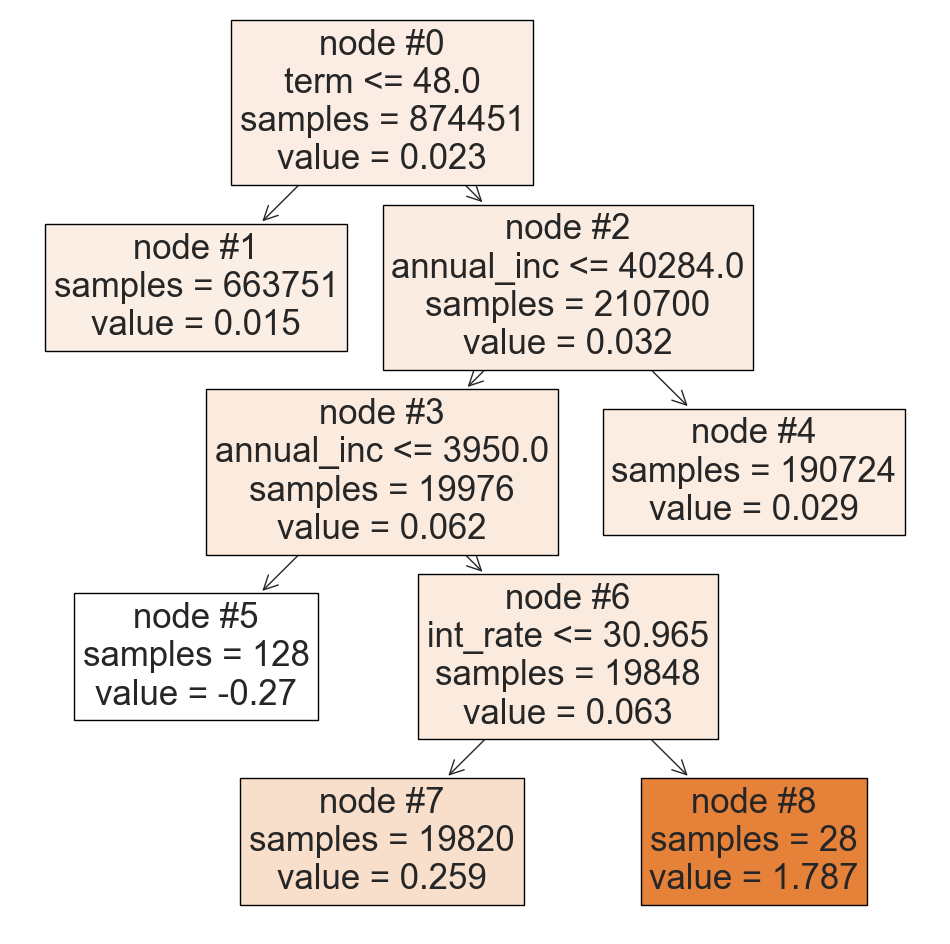

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
sk.tree.plot_tree(tree_estimator, impurity = False, filled=True, node_ids=True,
                 feature_names = feature_list, ax=ax)

In [19]:
fig.savefig(Path(setup.temp_path).joinpath('11_PLOT_simplified_tree.png'),
            bbox_inches='tight')

## Look at SHAP and ALE interactions for the tree

In [20]:
ale_cust = ale(X=train_samp_df[feature_list], model=tree_estimator, feature=['int_rate', 'term'], plot=False)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [21]:
shap_expl_cust = shap.TreeExplainer(tree_estimator.get_shap_model(), feature_names=feature_list)
shap_int_cust =  shap_expl_cust.shap_interaction_values(train_samp_df[feature_list])
shap_df = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_int_cust[:,1, 0]})],
                           axis=1)

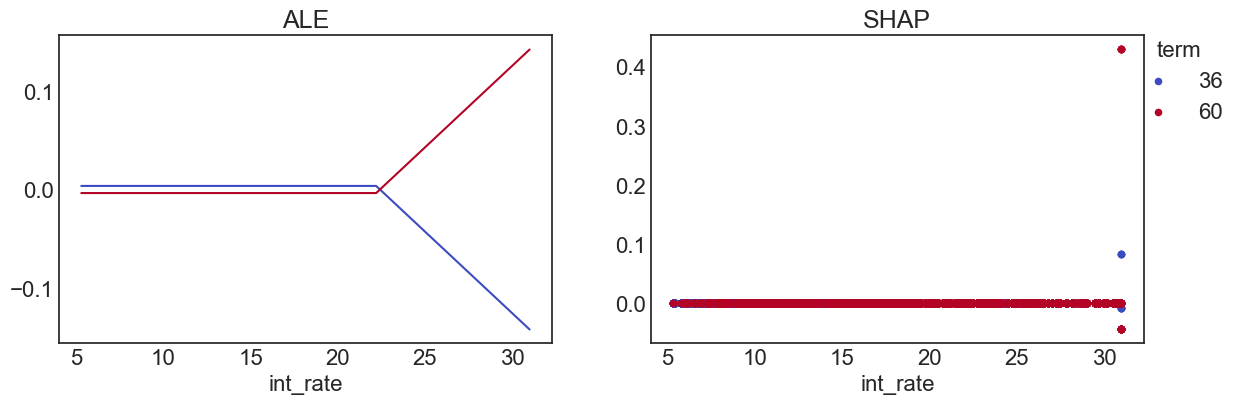

In [22]:
fig = ip_plot.plot_comp_ale_shap(ale_cust, shap_df)

In [23]:
fig.savefig(Path(setup.temp_path).joinpath('11_PLOT_ale_shap_curves.png'),
            bbox_inches='tight')

##### Same curve, crop outliers

The ALE curve for this very simple tree is similar to the curve for the base model.  The SHAP curve is much flatter with some outlier points at very high interest rate.  Smooth the curve to see trends at high interest rates

## Smooth the SHAP curve

In [24]:
# Function to smooth the SHAP data to re-plot
def shap_curve_smooth(data, q=50):
    data = data.copy()
    data['bin'] = pd.qcut(data['int_rate'], q=q)
    
    data_agg = data.groupby(['term', 'bin']) \
        .agg({'int_rate':'mean', 'shap':'mean'}) \
        .reset_index()
    
    return data_agg

In [25]:
shap_smooth_df = shap_curve_smooth(shap_df)

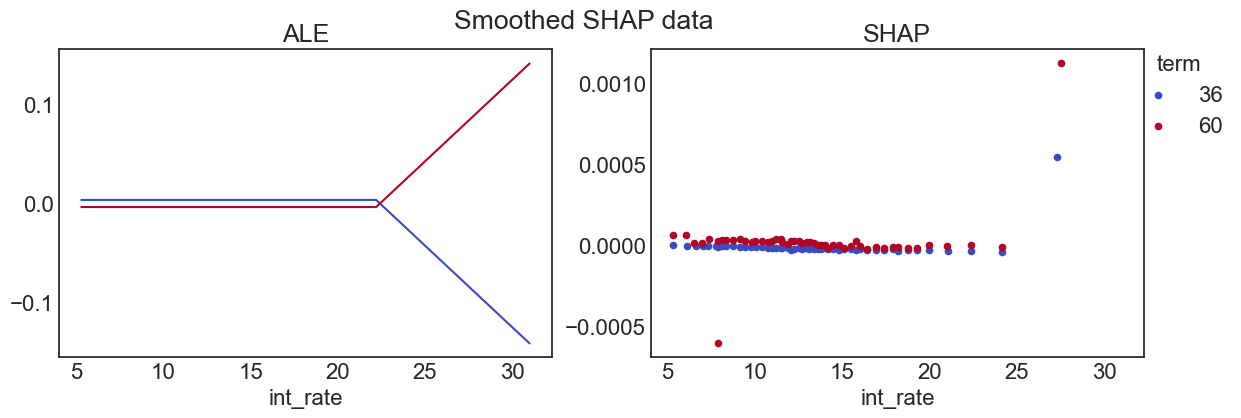

In [26]:
fig = ip_plot.plot_comp_ale_shap(ale_cust, shap_smooth_df, title='Smoothed SHAP data')

In [27]:
fig.savefig(Path(setup.temp_path).joinpath('11_PLOT_ale_shap_curves_smoothed.png'),
            bbox_inches='tight')

After smoothing, the curves show the discrepant behavior

## Re-Measure Curves, High Income Only

In [28]:
train_moderate_samp = train_samp_df[(train_samp_df['annual_inc'] > 45000)]

In [29]:
%%capture
ale_mod = ale(X=train_moderate_samp[feature_list], model=tree_estimator, feature=['int_rate', 'term'], plot=False)

In [30]:
shap_mod = shap_df.loc[train_moderate_samp.reset_index().index, :]

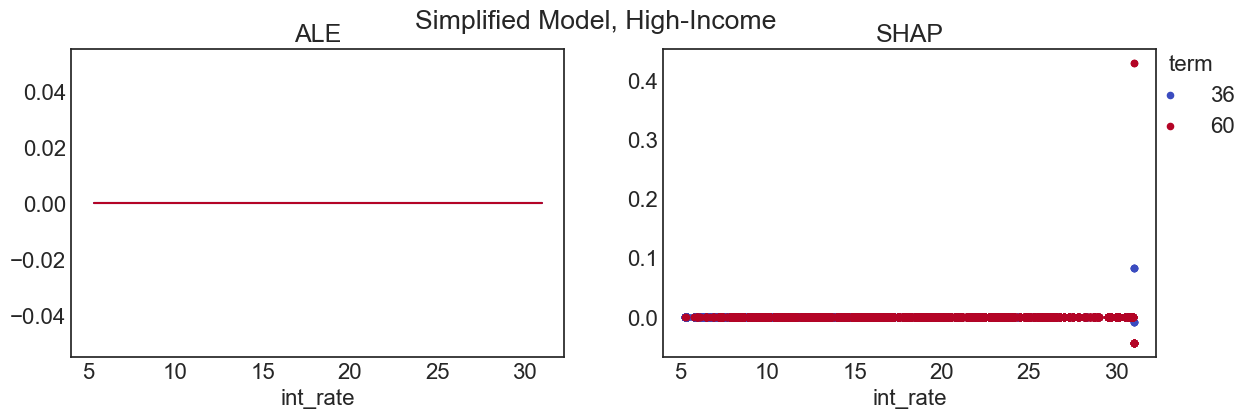

In [31]:
plt.close()
fig = ip_plot.plot_comp_ale_shap(ale_mod, shap_mod, title='Simplified Model, High-Income')

In [32]:
fig.savefig(Path(setup.temp_path).joinpath('11_PLOT_int_rate_term_high_inc.png'), bbox_inches='tight')

In [33]:
TO DO
Re-run and time scripts?
Think about how to demonstrate this sub-population is important in the main model?

SyntaxError: invalid syntax (466879314.py, line 1)

In [ ]:
SHAP high interest rate, 4-40k income borrowers, by term
maybe narrow income band say 38-42 k?
or do a logistic regression with interaction?  logistic regression for the model output not the data
(3 feature model - annual income (thresh or log), int rate, term and int rate x term)
or plot - default rate by income / term for high interest rate bororowers